<h1 style="text-align:center">Data Science for water consumption forecasting and anomaly detection</h1>
<h3 style="text-align:center">Nouamane Arhachoui</h3>
<hr>

In this notebook, you will find:
1. The way I have proceeded to predict the water consumption of a building based on its past data.
2. How to detect anomalies in order to alert people in the building.

<br>
<br>


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# 1. Water consumption prediction

### Step 1: understand the Dataset

In [2]:
data = pd.read_csv('water-consumption.csv', index_col='timestamp', parse_dates=True)

In [3]:
data

,pulses
timestamp,
2019-12-25 11:10:17,0
2019-12-25 11:16:17,0
2019-12-25 11:22:17,0
2019-12-25 11:28:20,0
2019-12-25 11:34:20,0
...,...
2020-12-23 09:59:22,20
2020-12-23 10:05:22,9
2020-12-23 10:11:22,0


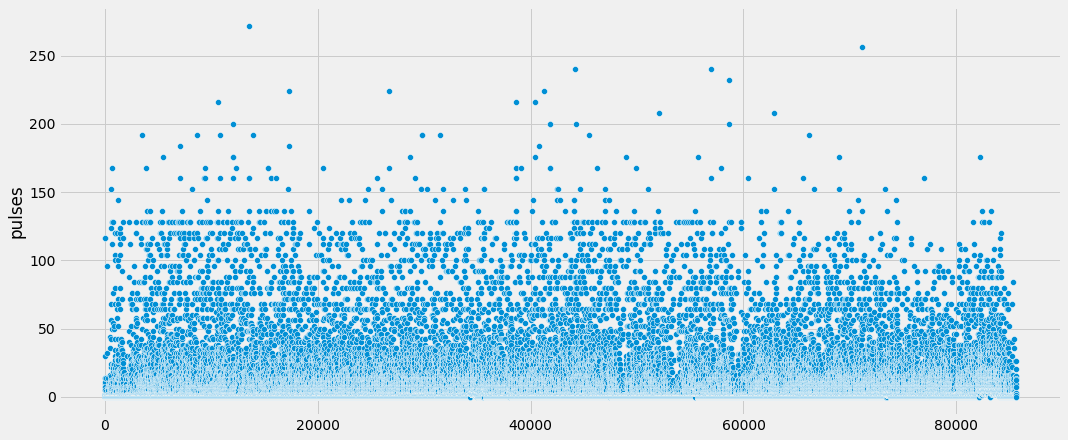

In [4]:
plt.figure(figsize=(16,7))
sns.scatterplot(x=np.arange(len(data.pulses)), y=data.pulses)
plt.show()

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
pulses,85592.0,7.16914,18.227112,0.0,0.0,0.0,5.0,272.0


First of all, looking at the scatter plot and the values above, I can notice that the pulses are measured aproximately every 6 minutes and that most of the time the pulse equals to zero.

By trying to do the prediction the first time, it was really bad because of this, so I decided to resample the dataset by considering the sum for each hour. Then, I've normalized the dataset in order to have values between 0 and 1 because, without doing this, the gaps between the maximum and most of the other values were very high.

In [6]:
data = data.resample('H').sum()

In [7]:
def normalize(x):
    return x/x.max()

In [8]:
data = data.apply(normalize)

In [9]:
data

,pulses
timestamp,
2019-12-25 11:00:00,0.198680
2019-12-25 12:00:00,0.001466
2019-12-25 13:00:00,0.006598
2019-12-25 14:00:00,0.000000
2019-12-25 15:00:00,0.022727
...,...
2020-12-23 06:00:00,0.003666
2020-12-23 07:00:00,0.014663
2020-12-23 08:00:00,0.023460


In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
pulses,8736.0,0.051496,0.075457,0.0,0.002199,0.024194,0.069648,1.0


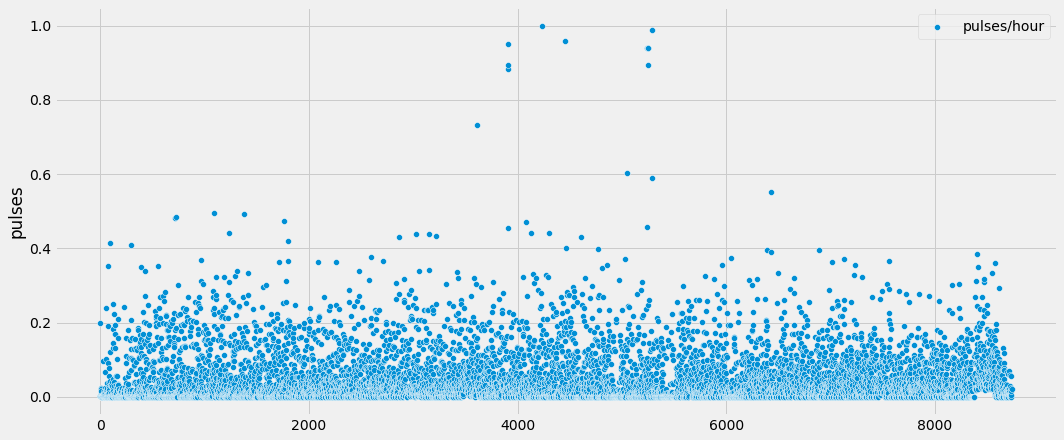

In [11]:
plt.figure(figsize=(16,7))
sns.scatterplot(x=np.arange(len(data.pulses)), y=data.pulses, label='pulses/hour')
plt.show()

Above, you can see that there are not so many values greater that 0.7. We can wonder if those values show some anomalies. Maybe, the model will enlighten me.

### Step 2: the model

In this part, I chose to split the data exactly one month before the end. Next, I used the Prophet model from the prophet library to predict the future consumption.

In [12]:
split_date = '2020-11-23'
train = data.loc[data.index <= split_date].copy()
test = data.loc[data.index > split_date].copy()

In [13]:
join_train_test = train \
                    .rename(columns={'pulses': 'train'}) \
                    .join(test.rename(columns={'pulses': 'test'}), how='outer')

<AxesSubplot:xlabel='timestamp'>

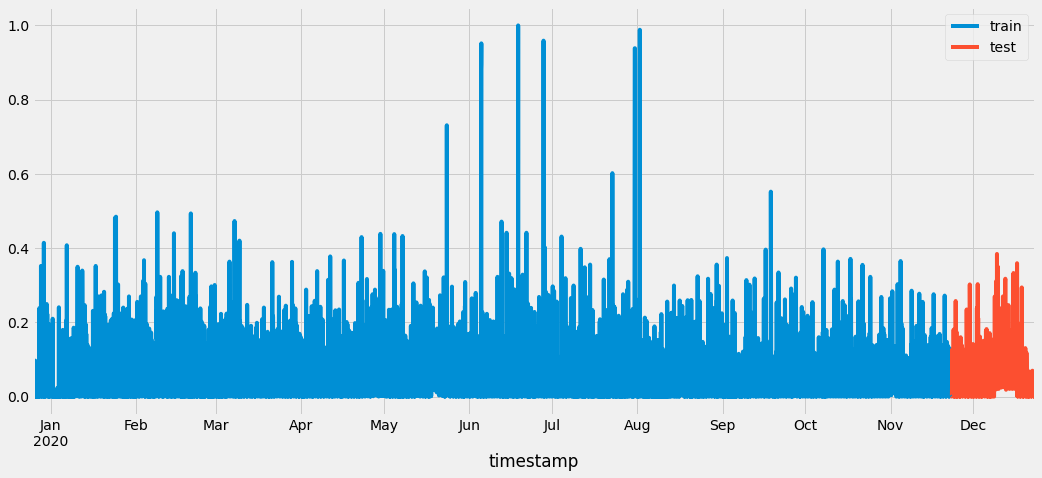

In [14]:
join_train_test.plot(figsize=(16,7))

Below, I added some features to the dataset in order to understand it even more before defining and training the model. These new features are the hour, the day, the month, etc. I did this to see if there is some sort of periodicity.

In [15]:
def create_features(df, target='pulses'):
    
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofmonth'] = df['date'].dt.day
    df.dropna(inplace=True)
    
    X = df[['hour', 'dayofweek','quarter','month','dayofmonth']]
    X.sort_index(inplace=True)
    
    if target:
        y = df[target]
        return X, y
    return X

In [16]:
X_train, y_train = create_features(train)
X_test, y_test = create_features(test)
X_y = pd.concat([X_train, y_train], axis=1)
X_y.head()

,hour,dayofweek,quarter,month,dayofmonth,pulses
timestamp,,,,,,
2019-12-25 11:00:00,11,2,4,12,25,0.198680
2019-12-25 12:00:00,12,2,4,12,25,0.001466
2019-12-25 13:00:00,13,2,4,12,25,0.006598
2019-12-25 14:00:00,14,2,4,12,25,0.000000
2019-12-25 15:00:00,15,2,4,12,25,0.022727


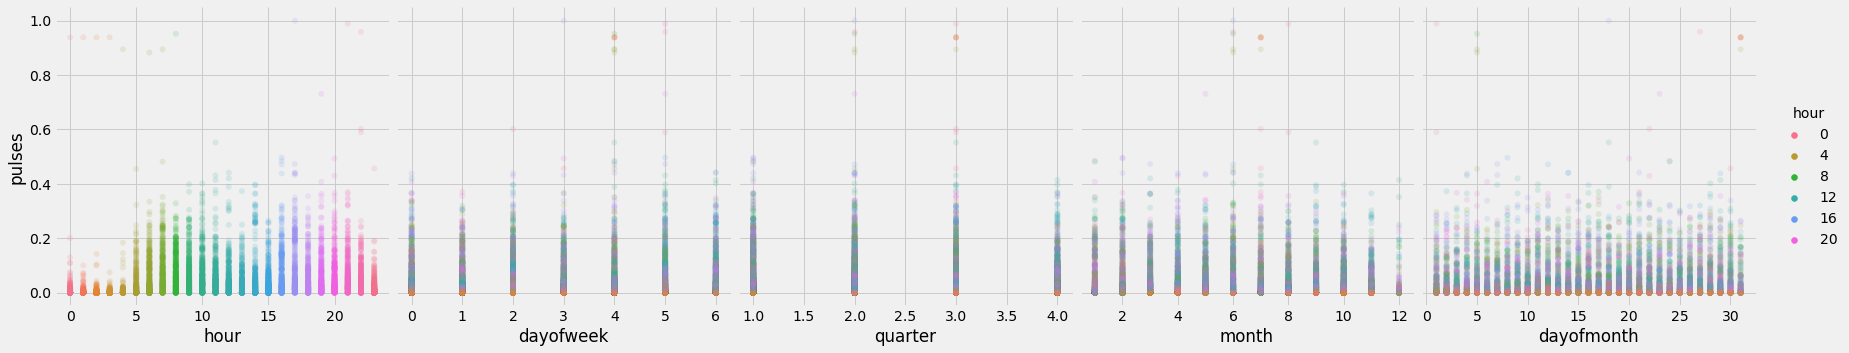

In [17]:
sns.pairplot(
    X_y,
    hue='hour',
    palette='husl',
    x_vars=['hour', 'dayofweek', 'quarter', 'month', 'dayofmonth'],
    y_vars='pulses',
    height=5,
    plot_kws={'alpha':0.15, 'linewidth':0}  # The more matching values there are, the more opaque the points will be.
)

The pairplot function is very interesting to see if there is a correlation between the features and the number of pulses. In fact, I noticed that the consumption is often high at the same hour of the day (the morning and at the start of the evening) and it is low the night, which seems logic.

Next, I define the model and then train it. I tried many values for the hyperparameters but I noticed that it does not affect the error so much so I sticked to the default values.

In [18]:
model = Prophet(yearly_seasonality=False) # yearly_seasonality=False because we have less that 1 year of data for training
model.fit(train.reset_index() \
              .rename(columns={'timestamp':'ds', 'pulses':'y'}))

### Step 3: Prediction

In [19]:
test_pred = model.predict(df=test.reset_index() \
                                   .rename(columns={'timestamp':'ds'}))

In [20]:
test_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-11-23 01:00:00,0.048796,-0.088382,0.093848,0.048796,0.048796,-0.049163,-0.049163,-0.049163,-0.048249,-0.048249,-0.048249,-0.000914,-0.000914,-0.000914,0.0,0.0,0.0,-0.000367
1,2020-11-23 02:00:00,0.048797,-0.106115,0.087250,0.048797,0.048797,-0.054630,-0.054630,-0.054630,-0.053611,-0.053611,-0.053611,-0.001019,-0.001019,-0.001019,0.0,0.0,0.0,-0.005833
2,2020-11-23 03:00:00,0.048797,-0.092512,0.092739,0.048797,0.048797,-0.049647,-0.049647,-0.049647,-0.048520,-0.048520,-0.048520,-0.001127,-0.001127,-0.001127,0.0,0.0,0.0,-0.000850
3,2020-11-23 04:00:00,0.048797,-0.083092,0.104120,0.048797,0.048797,-0.035286,-0.035286,-0.035286,-0.034047,-0.034047,-0.034047,-0.001238,-0.001238,-0.001238,0.0,0.0,0.0,0.013511
4,2020-11-23 05:00:00,0.048797,-0.064831,0.118038,0.048797,0.048797,-0.014941,-0.014941,-0.014941,-0.013589,-0.013589,-0.013589,-0.001353,-0.001353,-0.001353,0.0,0.0,0.0,0.033856


The plot_compenents function, that I use below, allows me to confirm my guesses on the evolution of the number of pulses over time. We can see that there is also a weekly seasonality.

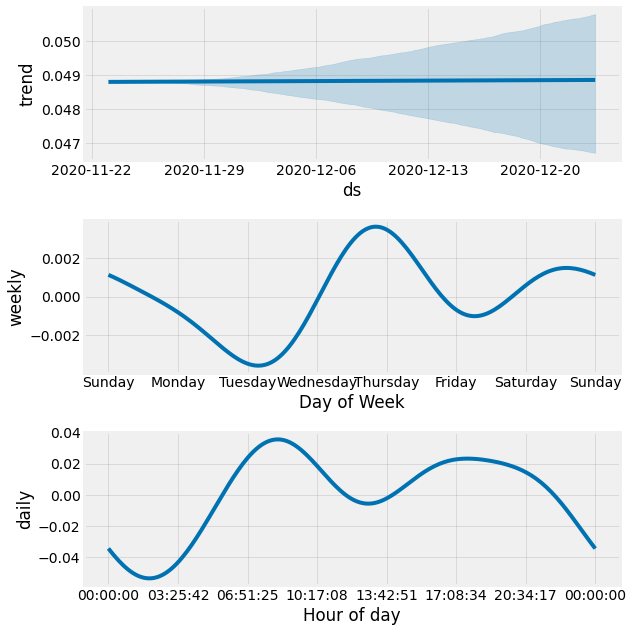

In [21]:
fig = model.plot_components(test_pred)

### Step 3: Visualizing and measuring the accuracy

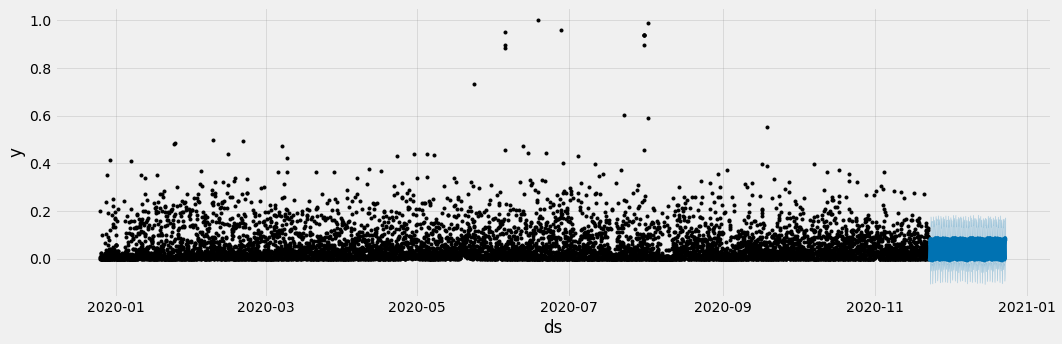

In [22]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(test_pred, ax=ax)
plt.show()

#### I did a zoom on the predicted part to better visualize it.

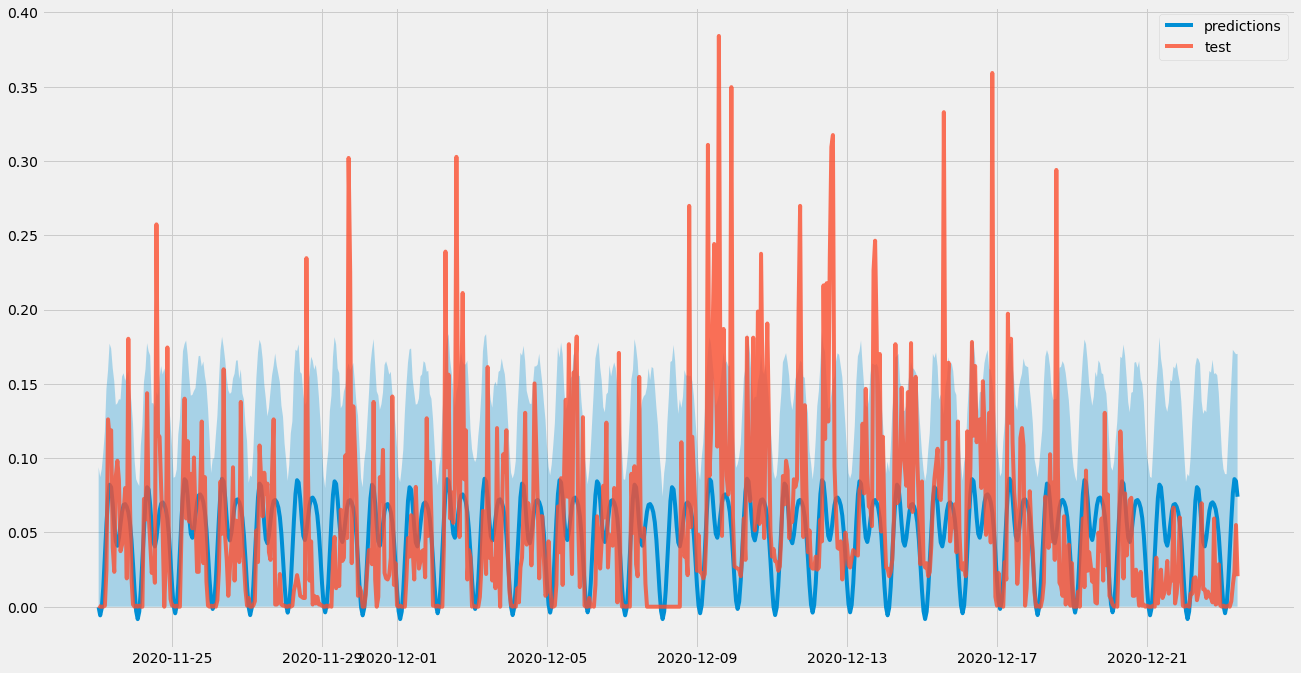

In [23]:
f, ax = plt.subplots(1)
f.set_figheight(11)
f.set_figwidth(20)

ax.plot(test_pred['ds'], test_pred['yhat'], label='predictions')
ax.plot(test.index, test['pulses'], label='test', alpha=0.8)
ax.fill_between(test_pred['ds'], test_pred['yhat_upper'], alpha=0.3)
ax.legend()

In [24]:
mean_squared_error(y_true=test['pulses'], y_pred=test_pred['yhat'])

0.0032895153895934107

In [25]:
mean_absolute_error(y_true=test['pulses'], y_pred=test_pred['yhat'])

0.03852248926302783

# 2. How to detect an anomaly?

We know that most of the time, the pulse equals to 0. It means that we can detect when the pulse is not 0 for too long period and then conclude that there is a problem.

For example, we can see that between December 9th and December 17th the water consumption never equals zero. It means that there may be a leak somewhere in the building and people have to be notified.